# Multi-pedestrian Dataset Tutorial

Author: [Zhe Huang](https://github.com/tedhuang96) <br/>
Date: Nov. 8, 2020 <br/>
The code base is heavily borrowed from [Social-STGCNN](https://github.com/abduallahmohamed/Social-STGCNN).

## 1. Set up source files, packages and arguments.

In [23]:
!git clone https://github.com/abduallahmohamed/Social-STGCNN.git

Cloning into 'Social-STGCNN'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 178 (delta 6), reused 2 (delta 1), pack-reused 163
Receiving objects: 100% (178/178), 5.87 MiB | 40.11 MiB/s, done.
Resolving deltas: 100% (57/57), done.


In [42]:
# Clone source files into Colab.
!git clone https://github.com/tedhuang96/torch_data_tutorial.git

Cloning into 'torch_data_tutorial'...
remote: Enumerating objects: 99, done.
remote: Counting objects: 100% (99/99), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 99 (delta 19), reused 93 (delta 17), pack-reused 0
Unpacking objects: 100% (99/99), done.


In [44]:
# Import packages and check GPU.
# 
### expected output: ###
### cuda:0 ### or ### cpu ###

import torch
import argparse
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from os import listdir
from os.path import join
from IPython.display import HTML
from matplotlib import animation, rc
from IPython.display import HTML

from torch_data_tutorial.utils import anorm, create_datasets
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [45]:
# Write arguments.
# 
### expected output: ###
### Namespace(attn_mech='auth', dataset='zara1', obs_seq_len=8, pred_seq_len=12) ###

def arg_parse_notebook(obs_seq_len, pred_seq_len, dataset, attn_mech):
    obs_seq_len, pred_seq_len = str(obs_seq_len), str(pred_seq_len)
    parser = argparse.ArgumentParser()
    parser.add_argument('--obs_seq_len', type=int, default=0)
    parser.add_argument('--pred_seq_len', type=int, default=0)
    parser.add_argument('--dataset', default='eth',
                        help='eth,hotel,univ,zara1,zara2')
    parser.add_argument('--attn_mech', default='glob_kip',
                        help='attention mechanism: glob_kip, auth')
    args_list = ['--obs_seq_len', obs_seq_len, '--pred_seq_len', pred_seq_len, '--dataset', dataset, '--attn_mech', attn_mech]
    return parser.parse_args(args_list)

obs_seq_len, pred_seq_len, dataset, attn_mech = 8, 12, 'zara1', 'auth'
args = arg_parse_notebook(obs_seq_len, pred_seq_len, dataset, attn_mech)
print(args)

Namespace(attn_mech='auth', dataset='zara1', obs_seq_len=8, pred_seq_len=12)


## 2. Introduce multi-pedestrian datasets.

Below are snapshots from ETH/UCY datasets. These datasets provide a [benchmark](http://trajnet.stanford.edu/) for multi-pedestrian trajectory prediction algorithms which are focused on pedestrian interaction mechanism. ETH contains two scenarios and UCY contains other three. They recorded and annotated pedestrian trajectories from a bird's eye view. The annotations include frame_id, pedestrian_id, x, y. 
![title](multi_pedestrian_scenarios.png)

In [46]:
# Load an example dataset into pandas.
# 
### expected output: ###
### filename:  torch_data_tutorial/datasets/zara1/train/train.txt ###
### data table: <traj_data_table> ###
pkg_path = 'torch_data_tutorial'
traj_data_folder = join(pkg_path, 'datasets', args.dataset, 'train') # may change 'datasets' to 'datasets_loo' for the leave-one-out setting.
traj_data_filepath = join(traj_data_folder, listdir(traj_data_folder)[0])
traj_data_table = pd.read_csv(traj_data_filepath, sep="\t", header=None)
traj_data_table.columns = ["frame_id", "ped_id", "x", "y"]
print('filename: ', traj_data_filepath)
print('data table: ')
print(traj_data_table)

filename:  torch_data_tutorial/datasets/zara1/train/train.txt
data table: 
      frame_id  ped_id          x         y
0          0.0     1.0  13.448721  3.937887
1          0.0     2.0  13.343488  4.439072
2          0.0     3.0  11.912325  4.439072
3          0.0     4.0  11.828139  5.155052
4          0.0     5.0   8.713256  4.415206
...        ...     ...        ...       ...
4302    7100.0   121.0  14.475580  3.583716
4303    7100.0   122.0   6.464436  4.193730
4304    7100.0   123.0   6.411188  5.311135
4305    7100.0   124.0   5.046532  4.710906
4306    7100.0   125.0   5.027801  3.962946

[4307 rows x 4 columns]


     frame_id  ped_id          x         y
0         0.0     1.0  13.448721  3.937887
8        10.0     1.0  12.935186  3.937887
16       20.0     1.0  12.421651  3.937887
25       30.0     1.0  11.919271  3.957695
34       40.0     1.0  11.428255  3.997552
43       50.0     1.0  10.937240  4.037408
52       60.0     1.0  10.467482  3.991824
61       70.0     1.0  10.019402  3.860800
70       80.0     1.0   9.571322  3.730014
79       90.0     1.0   9.093566  3.594933
88      100.0     1.0   8.571402  3.453407
97      110.0     1.0   8.049028  3.312121
106     120.0     1.0   7.519287  3.236227
116     130.0     1.0   6.985968  3.188495
126     140.0     1.0   6.452860  3.140763
136     150.0     1.0   5.909860  3.109737
146     160.0     1.0   5.362651  3.085871
156     170.0     1.0   4.815442  3.062005
166     180.0     1.0   4.303380  2.985157
175     190.0     1.0   3.806472  2.885874
184     200.0     1.0   3.309564  2.786353
194     210.0     1.0   2.816444  2.690412
204     220

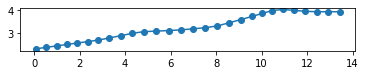

In [47]:
# Plot a pedestrian's trajectory.
# 
### expected output: ###
### <ped_traj> ###
### A trajectory plot corresponding to the pedestrian we queried. ###

ped_traj = traj_data_table.loc[traj_data_table['ped_id'] == 1]
print(ped_traj)
_, ax = plt.subplots()
ax.plot(ped_traj['x'], ped_traj['y'], 'o-')
ax.set_aspect('equal', adjustable='box')
plt.show()

   frame_id  ped_id          x         y
0       0.0     1.0  13.448721  3.937887
1       0.0     2.0  13.343488  4.439072
2       0.0     3.0  11.912325  4.439072
3       0.0     4.0  11.828139  5.155052
4       0.0     5.0   8.713256  4.415206
5       0.0     6.0   8.123953  3.460567
6       0.0     7.0   6.313953  3.842423
7       0.0     8.0   4.335581  7.350722


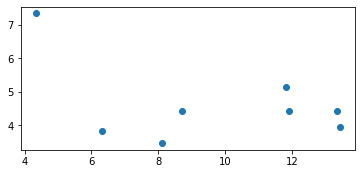

In [48]:
# Plot pedestrian positions in a frame.
# 
### expected output: ###
### <frame_pos> ###
### A scatter plot with each point representing a pedestrian position in that specific frame. ###

frame_pos = traj_data_table.loc[traj_data_table['frame_id']==0]
print(frame_pos)
_, ax = plt.subplots()
ax.plot(frame_pos['x'], frame_pos['y'], 'o')
ax.set_aspect('equal', adjustable='box')
plt.show()

In [49]:
# Animation of pedestrian motions in a 20-frame period.
# 
### expected output: ###
### A scatter plot animation with each point representing a pedestrian position. ###
### blue means the motion is during observation period, and ren means the motion is during prediction period. ###

fig, ax = plt.subplots()
ax.set_xlim((0, 16))
ax.set_ylim((2, 9))
ped_pos, = ax.plot([], [],'o')
plt.close()

def init():
    ped_pos.set_data([], [])
    return (ped_pos,)

def animate(i):
    frame_pos = traj_data_table.loc[traj_data_table['frame_id'] == i*10]
    x, y = frame_pos['x'], frame_pos['y']
    ped_pos.set_data(x, y)
    if i > 8:
        ped_pos.set_color('C3') # red
    return (ped_pos,)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=20, interval=200, blit=True)
HTML(anim.to_html5_video())

ped_ids shown up in all 20 frames: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 8.0]


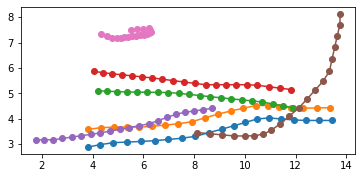

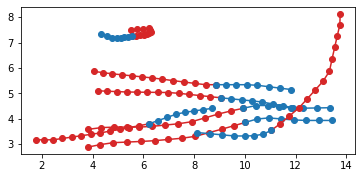

In [50]:
# We are interested in predicting pedestrian motion in the later 12 time steps
# given the observation in the first 8 time steps.
#
# We filter out common pedestrians across all 20 time steps,
# and their trajectories in these 20 time steps formed a data sample.
# 
### expected output: ###
### ped_ids shown up in all 20 frames: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 8.0] ###
### Two trajectory plots ###

ped_ids_20_frames = []
for i in range(0, 19):
    ped_ids_20_frames.append(set(traj_data_table.loc[traj_data_table['frame_id'] == i*10]['ped_id']))
common_ped_ids_20_frames = list(set.intersection(*ped_ids_20_frames))
print('ped_ids shown up in all 20 frames:', common_ped_ids_20_frames)


_, ax = plt.subplots()
for common_ped_id in common_ped_ids_20_frames[:8]: 
    ped_traj_pred = traj_data_table.loc[(traj_data_table['ped_id'] == common_ped_id) & (traj_data_table['frame_id'] <= 190)]
    ax.plot(ped_traj_pred['x'], ped_traj_pred['y'], 'o-')
ax.set_aspect('equal', adjustable='box')
plt.show()


_, ax = plt.subplots()
for common_ped_id in common_ped_ids_20_frames[:8]: 
    ped_traj_pred = traj_data_table.loc[(traj_data_table['ped_id'] == common_ped_id) & (traj_data_table['frame_id'] >= 70) \
                                       & (traj_data_table['frame_id'] <= 190)]
    ax.plot(ped_traj_pred['x'], ped_traj_pred['y'], 'o-', c='C3') # red
    ped_traj_obs = traj_data_table.loc[(traj_data_table['ped_id'] == common_ped_id) & (traj_data_table['frame_id'] < 80)]
    ax.plot(ped_traj_obs['x'], ped_traj_obs['y'], 'o-',c='C0') # blue
ax.set_aspect('equal', adjustable='box')
plt.show()



## 3. Customize a torch dataset for multi-pedestrian trajectory data.

Deep learning has become increasingly effective in learning patterns from data in recent years. We will use [PyTorch](https://pytorch.org) as our deep learning framework to handle multi-pedestrian trajectory prediction tasks.

The first step to accomplish the task is to build a dataset that algorithms developed in Pytorch can recognize as input. Check out TrajectoryDataset class in utils.py, which we will be using to create the dataset.

Extension: [Mini-batch Gradient Descent](https://xzz201920.medium.com/gradient-descent-stochastic-vs-mini-batch-vs-batch-vs-adagrad-vs-rmsprop-vs-adam-3aa652318b0d).

![title](sgd_bgd_mbgd.png)


In [51]:
### expected output: ###
# ['torch_data_tutorial/datasets/zara1/train/train.txt']
# Processing Data .....
# 100%
# 503/503 [00:11<00:00, 42.84it/s]
#
# ['torch_data_tutorial/datasets/zara1/val/val.txt']
# Processing Data .....
# 100%
# 85/85 [00:05<00:00, 15.75it/s]
#
# ['torch_data_tutorial/datasets/zara1/test/crowds_zara01.txt']
# Processing Data .....
# 100%
# 602/602 [00:13<00:00, 43.06it/s]

pkg_path = 'torch_data_tutorial'
dsets = create_datasets(args, pkg_path, save_datasets=True)

['torch_data_tutorial/datasets/zara1/train/train.txt']
Processing Data .....



torch_data_tutorial/datasets/zara1/zara1_dset_train_auth.pt is created.
['torch_data_tutorial/datasets/zara1/val/val.txt']
Processing Data .....



torch_data_tutorial/datasets/zara1/zara1_dset_val_auth.pt is created.
['torch_data_tutorial/datasets/zara1/test/crowds_zara01.txt']
Processing Data .....



torch_data_tutorial/datasets/zara1/zara1_dset_test_auth.pt is created.


In [54]:
dloader_train = DataLoader(
        dsets['train'],
        batch_size=1,
        shuffle=True,
        num_workers=1)

In [58]:
def get_batch_sample(loader_test, device='cuda:0'):
    batch_count = 1
    for cnt, batch in enumerate(loader_test):
        batch_count += 1
        # Get data
        batch = [tensor.to(device) for tensor in batch]
        # ** Name of variables in a batch
        # * obs_traj, pred_traj_gt, obs_traj_rel, pred_traj_gt_rel, non_linear_ped,\
        # *    loss_mask, V_obs, A_obs, V_tr, A_tr = batch
        var_names = [
            'obs_traj', 'pred_traj_gt', 'obs_traj_rel', 'pred_traj_gt_rel', 'non_linear_ped',
            'loss_mask', 'V_obs', 'A_obs', 'V_tr', 'A_tr']
        for var_name_i, batch_i in zip(var_names, batch):
            if var_name_i == 'obs_traj' and batch_i.shape[1] == 5: # get five-pedestrian case
                return batch

def visualize_dataloader(data_loader, attn_scale=1., device='cuda:0'):
    """
    visualize data and attention in a batch generated by data_loader.
    """
    batch = get_batch_sample(data_loader, device=device)
    obs_traj, pred_traj_gt, obs_traj_rel, pred_traj_gt_rel, non_linear_ped,\
        loss_mask, V_obs, A_obs, V_tr, A_tr = batch
    obs_ts = 2 # time of attention
    attn = A_obs[0, obs_ts]  # (num_peds, num_peds)
    fig, ax = plt.subplots()
    colors = 'rgggg'
#     attn_scale = 1. # size of attention circle
    for ped_i in range(obs_traj.shape[1]):
        x_obs_i = obs_traj[0, ped_i].to('cpu')
        x_gt_i = pred_traj_gt[0, ped_i].to('cpu')
        # ax.plot(x_obs_i[0, :], x_obs_i[1, :], 'o-', c='C0')
        x_concat_i = torch.cat([x_obs_i, x_gt_i], dim=1)
        ax.plot(x_concat_i[0, :], x_concat_i[1, :], 'o-',c='C3')
        ax.plot(x_obs_i[0, :], x_obs_i[1, :], 'o-', c='C0')
        ax.plot(x_obs_i[0, obs_ts], x_obs_i[1, obs_ts], 'ko-')
        # ax.plot(x_gt_i[0, :], x_gt_i[1, :], 'o-',c='C3')
        attn_i = plt.Circle(
            x_obs_i[:, obs_ts], abs(attn[ped_i, 0])*attn_scale, color=colors[ped_i], fill=False)
        ax.add_artist(attn_i)
    ax.set_aspect('equal', adjustable='box')
    plt.show()

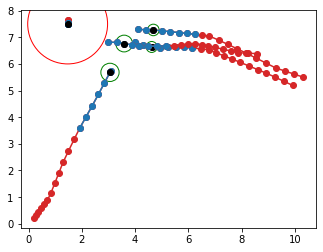

In [60]:
### expected output: ###
### Visualization on trajectories and attention ###

visualize_dataloader(dloader_train, attn_scale=1.5, device=device)

## 4. Train a Social-STGCNN model.

In [53]:
!python torch_data_tutorial/train.py --lr 0.01 --dataset zara1 --attn_mech auth --n_stgcnn 1 --n_txpcnn 5 --use_lrschd --num_epochs 200 && echo "Training on zara1 is complete."

******************************
Training initiating....
Namespace(attn_mech='auth', batch_size=128, clip_grad=None, dataset='zara1', input_size=2, kernel_size=3, lr=0.01, lr_sh_rate=150, n_stgcnn=1, n_txpcnn=5, num_epochs=200, obs_seq_len=8, output_size=5, pred_seq_len=12, tag='tag', use_lrschd=True)
torch_data_tutorial/datasets/zara1/zara1_dset_train_auth.pt is loaded.
torch_data_tutorial/datasets/zara1/zara1_dset_val_auth.pt is loaded.
Data and model loaded
Checkpoint dir: torch_data_tutorial/checkpoint/auth-zara1
Training started ...
/home/zhe/Documents/github_repo_test/torch_data_tutorial/torch_data_tutorial/model.py:160: UserWarning: Mixed memory format inputs detected while calling the operator. The operator will output contiguous tensor even if some of the inputs are in channels_last format. (Triggered internally at  /pytorch/aten/src/ATen/native/TensorIterator.cpp:918.)
  x = self.tcn(x) + res # zhe # residual learning
TRAIN: 	 Epoch: 0 	 Loss: 0.014755170792341232
TRAIN: 	 Epoc

TRAIN: 	 Epoch: 17 	 Loss: 0.0063673341646790504
TRAIN: 	 Epoch: 17 	 Loss: 0.005911568878218532
TRAIN: 	 Epoch: 17 	 Loss: 0.005483837643017371
TRAIN: 	 Epoch: 17 	 Loss: 0.005035579263808476
VALD: 	 Epoch: 17 	 Loss: 0.005669975631377276
******************************
Epoch: tag : 17
train_loss 0.005035579263808476
val_loss 0.005669975631377276
{'min_val_epoch': 16, 'min_val_loss': 0.0045542198068955365}
******************************
TRAIN: 	 Epoch: 18 	 Loss: 0.002672444563359022
TRAIN: 	 Epoch: 18 	 Loss: 0.002255566418170929
TRAIN: 	 Epoch: 18 	 Loss: 0.0018493836202348273
TRAIN: 	 Epoch: 18 	 Loss: 0.0017338816676414747
VALD: 	 Epoch: 18 	 Loss: 0.02690574702094583
******************************
Epoch: tag : 18
train_loss 0.0017338816676414747
val_loss 0.02690574702094583
{'min_val_epoch': 16, 'min_val_loss': 0.0045542198068955365}
******************************
TRAIN: 	 Epoch: 19 	 Loss: 0.0023402487859129906
TRAIN: 	 Epoch: 19 	 Loss: 0.004503578646108508
TRAIN: 	 Epoch: 19 	 

VALD: 	 Epoch: 35 	 Loss: 0.012954986796659582
******************************
Epoch: tag : 35
train_loss -0.0008303302656822129
val_loss 0.012954986796659582
{'min_val_epoch': 24, 'min_val_loss': -0.0006711152546546038}
******************************
TRAIN: 	 Epoch: 36 	 Loss: -0.003075268119573593
TRAIN: 	 Epoch: 36 	 Loss: -0.003294057329185307
TRAIN: 	 Epoch: 36 	 Loss: -0.003409638690451781
TRAIN: 	 Epoch: 36 	 Loss: -0.0031414781484167807
VALD: 	 Epoch: 36 	 Loss: 0.027074112611658433
******************************
Epoch: tag : 36
train_loss -0.0031414781484167807
val_loss 0.027074112611658433
{'min_val_epoch': 24, 'min_val_loss': -0.0006711152546546038}
******************************
TRAIN: 	 Epoch: 37 	 Loss: 0.003759886370971799
TRAIN: 	 Epoch: 37 	 Loss: 0.002740131283644587
TRAIN: 	 Epoch: 37 	 Loss: 0.001758544128582192
TRAIN: 	 Epoch: 37 	 Loss: 0.001002274679527368
VALD: 	 Epoch: 37 	 Loss: 0.01863391399383545
******************************
Epoch: tag : 37
train_loss 0.001

TRAIN: 	 Epoch: 54 	 Loss: -0.0054827528074383736
TRAIN: 	 Epoch: 54 	 Loss: -0.005761705106124282
TRAIN: 	 Epoch: 54 	 Loss: -0.005845996706436078
TRAIN: 	 Epoch: 54 	 Loss: -0.005912109705847253
VALD: 	 Epoch: 54 	 Loss: 0.030539537878597485
******************************
Epoch: tag : 54
train_loss -0.005912109705847253
val_loss 0.030539537878597485
{'min_val_epoch': 24, 'min_val_loss': -0.0006711152546546038}
******************************
TRAIN: 	 Epoch: 55 	 Loss: -0.004345659166574478
TRAIN: 	 Epoch: 55 	 Loss: -0.0009659618372097611
TRAIN: 	 Epoch: 55 	 Loss: -0.0008733022647599379
TRAIN: 	 Epoch: 55 	 Loss: -0.001212060096012669
VALD: 	 Epoch: 55 	 Loss: -5.820947425330386e-05
******************************
Epoch: tag : 55
train_loss -0.001212060096012669
val_loss -5.820947425330386e-05
{'min_val_epoch': 24, 'min_val_loss': -0.0006711152546546038}
******************************
TRAIN: 	 Epoch: 56 	 Loss: -0.003396790474653244
TRAIN: 	 Epoch: 56 	 Loss: -0.003980865702033043
TRA

TRAIN: 	 Epoch: 72 	 Loss: -0.0024735929359261605
VALD: 	 Epoch: 72 	 Loss: -0.001589094365344328
******************************
Epoch: tag : 72
train_loss -0.0024735929359261605
val_loss -0.001589094365344328
{'min_val_epoch': 59, 'min_val_loss': -0.004392944013371187}
******************************
TRAIN: 	 Epoch: 73 	 Loss: -0.0021850403863936663
TRAIN: 	 Epoch: 73 	 Loss: -0.0025393649702891707
TRAIN: 	 Epoch: 73 	 Loss: -0.003131718607619405
TRAIN: 	 Epoch: 73 	 Loss: -0.003580069743378262
VALD: 	 Epoch: 73 	 Loss: -0.004528983550913194
******************************
Epoch: tag : 73
train_loss -0.003580069743378262
val_loss -0.004528983550913194
{'min_val_epoch': 73, 'min_val_loss': -0.004528983550913194}
******************************
TRAIN: 	 Epoch: 74 	 Loss: -0.006161940284073353
TRAIN: 	 Epoch: 74 	 Loss: -0.006458983523771167
TRAIN: 	 Epoch: 74 	 Loss: -0.006868292888005574
TRAIN: 	 Epoch: 74 	 Loss: -0.006984126378243296
VALD: 	 Epoch: 74 	 Loss: 0.0011532499509699205
*****

TRAIN: 	 Epoch: 91 	 Loss: -0.00635917903855443
TRAIN: 	 Epoch: 91 	 Loss: -0.006865105126053095
TRAIN: 	 Epoch: 91 	 Loss: -0.007416214793920517
TRAIN: 	 Epoch: 91 	 Loss: -0.00761202149552332
VALD: 	 Epoch: 91 	 Loss: 0.022267466432908
******************************
Epoch: tag : 91
train_loss -0.00761202149552332
val_loss 0.022267466432908
{'min_val_epoch': 90, 'min_val_loss': -0.005202156655928668}
******************************
TRAIN: 	 Epoch: 92 	 Loss: -0.008476405404508114
TRAIN: 	 Epoch: 92 	 Loss: -0.007422411814332008
TRAIN: 	 Epoch: 92 	 Loss: -0.004340261220932007
TRAIN: 	 Epoch: 92 	 Loss: -0.0038848163237865593
VALD: 	 Epoch: 92 	 Loss: -0.003890185145770802
******************************
Epoch: tag : 92
train_loss -0.0038848163237865593
val_loss -0.003890185145770802
{'min_val_epoch': 90, 'min_val_loss': -0.005202156655928668}
******************************
TRAIN: 	 Epoch: 93 	 Loss: -0.004611635580658913
TRAIN: 	 Epoch: 93 	 Loss: -0.005315354093909264
TRAIN: 	 Epoch: 9

TRAIN: 	 Epoch: 109 	 Loss: -0.0042583831913665555
VALD: 	 Epoch: 109 	 Loss: -0.005438901746974272
******************************
Epoch: tag : 109
train_loss -0.0042583831913665555
val_loss -0.005438901746974272
{'min_val_epoch': 109, 'min_val_loss': -0.005438901746974272}
******************************
TRAIN: 	 Epoch: 110 	 Loss: -0.007395752239972353
TRAIN: 	 Epoch: 110 	 Loss: -0.007698482135310769
TRAIN: 	 Epoch: 110 	 Loss: -0.00807077701513966
TRAIN: 	 Epoch: 110 	 Loss: -0.008388042331452872
VALD: 	 Epoch: 110 	 Loss: 0.03916148858911851
******************************
Epoch: tag : 110
train_loss -0.008388042331452872
val_loss 0.03916148858911851
{'min_val_epoch': 109, 'min_val_loss': -0.005438901746974272}
******************************
TRAIN: 	 Epoch: 111 	 Loss: -0.010095511563122272
TRAIN: 	 Epoch: 111 	 Loss: -0.009942211676388979
TRAIN: 	 Epoch: 111 	 Loss: -0.010053003517289957
TRAIN: 	 Epoch: 111 	 Loss: -0.010004337928878147
VALD: 	 Epoch: 111 	 Loss: 0.0377878076889935

VALD: 	 Epoch: 127 	 Loss: 0.007829330247991225
******************************
Epoch: tag : 127
train_loss -0.010102187899898581
val_loss 0.007829330247991225
{'min_val_epoch': 119, 'min_val_loss': -0.0061963074347552135}
******************************
TRAIN: 	 Epoch: 128 	 Loss: -0.010705067776143551
TRAIN: 	 Epoch: 128 	 Loss: -0.009835438337177038
TRAIN: 	 Epoch: 128 	 Loss: -0.006189643482988079
TRAIN: 	 Epoch: 128 	 Loss: -0.00441464743249222
VALD: 	 Epoch: 128 	 Loss: -0.004237213906119851
******************************
Epoch: tag : 128
train_loss -0.00441464743249222
val_loss -0.004237213906119851
{'min_val_epoch': 119, 'min_val_loss': -0.0061963074347552135}
******************************
TRAIN: 	 Epoch: 129 	 Loss: -0.004654991440474987
TRAIN: 	 Epoch: 129 	 Loss: -0.005332004278898239
TRAIN: 	 Epoch: 129 	 Loss: -0.005727310354510943
TRAIN: 	 Epoch: 129 	 Loss: -0.006178134952340401
VALD: 	 Epoch: 129 	 Loss: -0.005959775868584128
******************************
Epoch: tag : 1

TRAIN: 	 Epoch: 146 	 Loss: -0.011009670794010162
TRAIN: 	 Epoch: 146 	 Loss: -0.011066773906350136
TRAIN: 	 Epoch: 146 	 Loss: -0.011171723095079264
TRAIN: 	 Epoch: 146 	 Loss: -0.011233672707028701
VALD: 	 Epoch: 146 	 Loss: 0.0008684845531688017
******************************
Epoch: tag : 146
train_loss -0.011233672707028701
val_loss 0.0008684845531688017
{'min_val_epoch': 131, 'min_val_loss': -0.007146914566264433}
******************************
TRAIN: 	 Epoch: 147 	 Loss: -0.009197243489325047
TRAIN: 	 Epoch: 147 	 Loss: -0.004094407835509628
TRAIN: 	 Epoch: 147 	 Loss: -0.0034517148742452264
TRAIN: 	 Epoch: 147 	 Loss: -0.004004185971161481
VALD: 	 Epoch: 147 	 Loss: -0.005973552956300623
******************************
Epoch: tag : 147
train_loss -0.004004185971161481
val_loss -0.005973552956300623
{'min_val_epoch': 131, 'min_val_loss': -0.007146914566264433}
******************************
TRAIN: 	 Epoch: 148 	 Loss: -0.006450957152992487
TRAIN: 	 Epoch: 148 	 Loss: -0.0073479174

TRAIN: 	 Epoch: 164 	 Loss: -0.01256086646268765
TRAIN: 	 Epoch: 164 	 Loss: -0.012378788373579325
VALD: 	 Epoch: 164 	 Loss: 0.039922142028808595
******************************
Epoch: tag : 164
train_loss -0.012378788373579325
val_loss 0.039922142028808595
{'min_val_epoch': 154, 'min_val_loss': -0.008629228087032542}
******************************
TRAIN: 	 Epoch: 165 	 Loss: -0.013021176680922508
TRAIN: 	 Epoch: 165 	 Loss: -0.012668119743466377
TRAIN: 	 Epoch: 165 	 Loss: -0.01253259958078464
TRAIN: 	 Epoch: 165 	 Loss: -0.012455879575452558
VALD: 	 Epoch: 165 	 Loss: -0.004804010250989129
******************************
Epoch: tag : 165
train_loss -0.012455879575452558
val_loss -0.004804010250989129
{'min_val_epoch': 154, 'min_val_loss': -0.008629228087032542}
******************************
TRAIN: 	 Epoch: 166 	 Loss: -0.012782749719917774
TRAIN: 	 Epoch: 166 	 Loss: -0.012566278222948313
TRAIN: 	 Epoch: 166 	 Loss: -0.012526276831825575
TRAIN: 	 Epoch: 166 	 Loss: -0.012400138686238

VALD: 	 Epoch: 182 	 Loss: 0.04863640841315774
******************************
Epoch: tag : 182
train_loss -0.012726804608142163
val_loss 0.04863640841315774
{'min_val_epoch': 154, 'min_val_loss': -0.008629228087032542}
******************************
TRAIN: 	 Epoch: 183 	 Loss: -0.0130820507183671
TRAIN: 	 Epoch: 183 	 Loss: -0.012942360248416662
TRAIN: 	 Epoch: 183 	 Loss: -0.012929416882495085
TRAIN: 	 Epoch: 183 	 Loss: -0.012745416662091053
VALD: 	 Epoch: 183 	 Loss: 0.09692744086770451
******************************
Epoch: tag : 183
train_loss -0.012745416662091053
val_loss 0.09692744086770451
{'min_val_epoch': 154, 'min_val_loss': -0.008629228087032542}
******************************
TRAIN: 	 Epoch: 184 	 Loss: -0.012763319537043571
TRAIN: 	 Epoch: 184 	 Loss: -0.012677931692451239
TRAIN: 	 Epoch: 184 	 Loss: -0.012674637759725252
TRAIN: 	 Epoch: 184 	 Loss: -0.01272839414433504
VALD: 	 Epoch: 184 	 Loss: 0.04194413914399989
******************************
Epoch: tag : 184
train_lo

In [25]:
!cp -r social-stgcnn-zara1 torch_data_tutorial/checkpoint

In [60]:
!python test.py

**************************************************
Number of samples: 20
**************************************************
1
Model being tested are: ['torch_data_tutorial/checkpoint/auth-zara1']
**************************************************
Evaluating model: torch_data_tutorial/checkpoint/auth-zara1
Stats: {'min_val_epoch': 154, 'min_val_loss': -0.008629228087032542}
torch_data_tutorial/datasets/zara1/zara1_dset_test_auth.pt is loaded.
Testing ....
/home/zhe/Documents/github_repo_test/torch_data_tutorial/model.py:160: UserWarning: Mixed memory format inputs detected while calling the operator. The operator will output contiguous tensor even if some of the inputs are in channels_last format. (Triggered internally at  /pytorch/aten/src/ATen/native/TensorIterator.cpp:918.)
  x = self.tcn(x) + res # zhe # residual learning
ADE: 0.4282439249927987  FDE: 0.5827810234171761


In [29]:
!python test.py --pretrained

**************************************************
Number of samples: 20
**************************************************
1
Model being tested are: ['torch_data_tutorial/checkpoint/social-stgcnn-zara1']
**************************************************
Evaluating model: torch_data_tutorial/checkpoint/social-stgcnn-zara1
Stats: {'min_val_epoch': 196, 'min_val_loss': -0.01428595929106405}
torch_data_tutorial/datasets/zara1/zara1_dset_test_auth.pt is loaded.
Testing ....
/home/zhe/Documents/github_repo_test/torch_data_tutorial/model.py:160: UserWarning: Mixed memory format inputs detected while calling the operator. The operator will output contiguous tensor even if some of the inputs are in channels_last format. (Triggered internally at  /pytorch/aten/src/ATen/native/TensorIterator.cpp:918.)
  x = self.tcn(x) + res # zhe # residual learning
ADE: 0.3418349037578422  FDE: 0.5292767553247331


**************************************************
Number of samples: 5
**************************************************
1
Model being tested are: ['torch_data_tutorial/checkpoint/auth-zara1']
**************************************************
Evaluating model: torch_data_tutorial/checkpoint/auth-zara1
Stats: {'min_val_epoch': 154, 'min_val_loss': -0.008629228087032542}
torch_data_tutorial/datasets/zara1/zara1_dset_test_auth.pt is loaded.
Testing ....


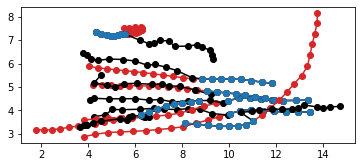

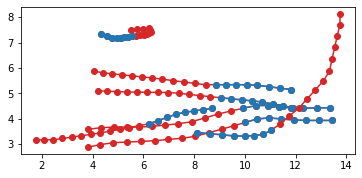

ADE: 1.1114493715590001  FDE: 1.87948866449309


In [3]:
import os
import math
import sys
sys.path.append('.')
pkg_path = 'torch_data_tutorial'
import torch
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import pickle
import glob
import matplotlib.pyplot as plt
import torch.distributions.multivariate_normal as torchdist
from torch_data_tutorial.utils import load_dataset
from torch_data_tutorial.metrics import ade, fde, seq_to_nodes, nodes_rel_to_nodes_abs
from torch_data_tutorial.model import social_stgcnn
import copy

pretrained=True


def test(KSTEPS=20):
    global loader_test,model
    model.eval()
    ade_bigls = []
    fde_bigls = []
    raw_data_dict = {}
    step =0 
    for batch in loader_test: 
        step+=1
        #Get data
        batch = [tensor.cuda() for tensor in batch]
        obs_traj, pred_traj_gt, obs_traj_rel, pred_traj_gt_rel, non_linear_ped,\
            loss_mask,V_obs,A_obs,V_tr,A_tr = batch
        num_of_objs = obs_traj_rel.shape[1]
        V_obs_tmp =V_obs.permute(0,3,1,2)
        V_pred,_ = model(V_obs_tmp,A_obs.squeeze())
        V_pred = V_pred.permute(0,2,3,1)
        V_tr = V_tr.squeeze()
        A_tr = A_tr.squeeze()
        V_pred = V_pred.squeeze()
        num_of_objs = obs_traj_rel.shape[1]
        V_pred,V_tr =  V_pred[:,:num_of_objs,:],V_tr[:,:num_of_objs,:] 
        sx = torch.exp(V_pred[:,:,2]) #sx
        sy = torch.exp(V_pred[:,:,3]) #sy
        corr = torch.tanh(V_pred[:,:,4]) #corr
        cov = torch.zeros(V_pred.shape[0],V_pred.shape[1],2,2).cuda()
        cov[:,:,0,0]= sx*sx
        cov[:,:,0,1]= corr*sx*sy
        cov[:,:,1,0]= corr*sx*sy
        cov[:,:,1,1]= sy*sy
        mean = V_pred[:,:,0:2]
        mvnormal = torchdist.MultivariateNormal(mean,cov)
        ### Rel to abs
        #Now sample 20 samples
        ade_ls = {}
        fde_ls = {}
        V_x = seq_to_nodes(obs_traj.data.cpu().numpy().copy()) # obs
        V_x_rel_to_abs = nodes_rel_to_nodes_abs(V_obs.data.cpu().numpy().squeeze().copy(),
                                                 V_x[0,:,:].copy())
        V_y = seq_to_nodes(pred_traj_gt.data.cpu().numpy().copy()) # target
        V_y_rel_to_abs = nodes_rel_to_nodes_abs(V_tr.data.cpu().numpy().squeeze().copy(),
                                                 V_x[-1,:,:].copy())
        raw_data_dict[step] = {}
        raw_data_dict[step]['obs'] = copy.deepcopy(V_x_rel_to_abs)
        raw_data_dict[step]['trgt'] = copy.deepcopy(V_y_rel_to_abs)
        raw_data_dict[step]['pred'] = []
        for n in range(num_of_objs): # num_peds
            ade_ls[n]=[]
            fde_ls[n]=[]
        for k in range(KSTEPS):
            fig, ax = plt.subplots()
            fig_no_pred, ax_no_pred = plt.subplots()
            V_pred = mvnormal.sample()
            V_pred_rel_to_abs = nodes_rel_to_nodes_abs(V_pred.data.cpu().numpy().squeeze().copy(),
                                                     V_x[-1,:,:].copy())
            raw_data_dict[step]['pred'].append(copy.deepcopy(V_pred_rel_to_abs))
           # print(V_pred_rel_to_abs.shape) #(12, 3, 2) = seq, ped, location
            for n in range(num_of_objs):
                pred = [] 
                target = []
                obsrvs = [] 
                number_of = []
                pred.append(V_pred_rel_to_abs[:,n:n+1,:])
                target.append(V_y_rel_to_abs[:,n:n+1,:])
                obsrvs.append(V_x_rel_to_abs[:,n:n+1,:])
                number_of.append(1)
                ### visualization starts ###
                vis_obs = V_x_rel_to_abs[:,n] # (8, 2)
                vis_target = target[-1][:,0] # (12, 2)
                vis_pred = pred[-1][:,0] # (12, 2)
                
                vis_obs_target = np.concatenate([vis_obs, vis_target], axis=0)
                vis_obs_pred = np.concatenate([vis_obs, vis_pred], axis=0)
                ax.plot(vis_obs_target[:,0], vis_obs_target[:,1], 'o-',c='C3')
                ax.plot(vis_obs_pred[:,0], vis_obs_pred[:,1], 'o-',c='k')
                ax.plot(vis_obs[:,0], vis_obs[:,1], 'o-',c='C0')
                
                ax_no_pred.plot(vis_obs_target[:,0], vis_obs_target[:,1], 'o-',c='C3')
                ax_no_pred.plot(vis_obs[:,0], vis_obs[:,1], 'o-',c='C0')
                
#                 ax.plot(V_x_rel_to_abs[:,n,0], V_x_rel_to_abs[:,n,1], 'o-',c='C0')
#                 ax.plot(pred[-1][:,0, 0],pred[-1][:,0, 1], 'o-',c='k')
#                 ax.plot(target[-1][:,0, 0],target[-1][:,0, 1], 'o-',c='C3')
                ### visualization starts ###
                ade_ls[n].append(ade(pred,target,number_of))
                fde_ls[n].append(fde(pred,target,number_of))
            ax.set_aspect('equal', adjustable='box')
            ax_no_pred.set_aspect('equal', adjustable='box')
            plt.show()
            break
            
        for n in range(num_of_objs):
            ade_bigls.append(min(ade_ls[n]))
            fde_bigls.append(min(fde_ls[n]))
        
        break

    ade_ = sum(ade_bigls)/len(ade_bigls)
    fde_ = sum(fde_bigls)/len(fde_bigls)
    return ade_,fde_,raw_data_dict

# if pretrained:
#     # paths = ['torch_data_tutorial/checkpoint/social-stgcnn-zara1']
# else:
#     paths = ['torch_data_tutorial/checkpoint/auth-zara1']
paths = ['torch_data_tutorial/checkpoint/auth-zara1']
# paths = ['torch_data_tutorial/checkpoint/social-stgcnn-zara1']
KSTEPS=5

print("*"*50)
print('Number of samples:',KSTEPS)
print("*"*50)

print(len(paths))


for feta in range(len(paths)):
    ade_ls = [] 
    fde_ls = [] 
    path = paths[feta]
    exps = glob.glob(path)
    print('Model being tested are:',exps)

    for exp_path in exps:
        print("*"*50)
        print("Evaluating model:",exp_path)

        model_path = exp_path+'/val_best.pth'
        args_path = exp_path+'/args.pkl'
        with open(args_path,'rb') as f: 
            args = pickle.load(f)
        
        if pretrained:
            args.attn_mech = 'auth'

        stats= exp_path+'/constant_metrics.pkl'
        with open(stats,'rb') as f: 
            cm = pickle.load(f)
        print("Stats:",cm)



        #Data prep     
        obs_seq_len = args.obs_seq_len
        pred_seq_len = args.pred_seq_len
        loader_test = load_dataset(args, pkg_path, subfolder='test', num_workers=1)

        #Defining the model 
        model = social_stgcnn(n_stgcnn =args.n_stgcnn,n_txpcnn=args.n_txpcnn,
        output_feat=args.output_size,seq_len=args.obs_seq_len,
        kernel_size=args.kernel_size,pred_seq_len=args.pred_seq_len).cuda()
        model.load_state_dict(torch.load(model_path))

        print("Testing ....")
        ad,fd,raw_data_dic_= test()

